# A simple macrostructural model in Modelflow

Modelflow is a sophisticated tool that can deal with extremely large and complicated models, including the Federal Reserve's and the World Bank's climate-aware macrostructural models.  In this chapter we illustrate some of the main features of modelflow using a very simple macrostructural model.  In the following chapter we look at the same features in a full-blown macro-structural model.

## Setting up the environment

As always we need to set up our python environment by importing the classes and modules upon which our program(s) will depend.

In [1]:
#import import_ipynb
#pip install import-ipynb 
%matplotlib Notebook
from modelclass import model 
from modelgrabwf2 import GrabWfModel
import modelpattern as pt #Allows pattern a selections from model structures
import re
import pandas as pd
model.widescreen()
model.scroll_off()
%load_ext autoreload
%autoreload 2

## Load a pre-existing Eviews model

In this simple example we will load a simple real-side only macroeconomic model that was created in EViews.  The model structure is simple.  Its i comprised of two  identities:

$$ Y_t=CPV_t + I_t + G_t + (X_t - M_t) + Y^{statdisc}_t $$
$$ GDE_t=CPV_t + I_t + G_t + X_t$$

and four behavioural equations variables for private consumption ($CPV$), Investment ($I$), for Government spending ($G$) and Imports ($M$).

$$ CPV_t = C'( \chi _t) + \eta^C_t $$
$$ I_t = I'( \chi _t) + \eta^I_t $$
$$ G_t = G'( \chi _t) + \eta^G_t $$
$$ M_t = X'( \chi _t) + \eta^M_t $$

and two exogenous variables ($X$ for exports and $Y^{statdisc}$ for the statistical discrepancy.

Each of the behaviourals is a simple error correction equation written as :

$$ \Delta var_t = - \gamma *(var_{t-1}- base_{t-1} - \beta_2 ) 2 ) + \Delta base_t $$

where for each $var \in (CPV,I,G)$ the base is $Y$, while for M it is GDE.

### Load a model -- the method ```.modelload()```

The modelflow method ```.modellow``` opens a pre-existing modelflow model, and assigns the variable ```msimple``` with the model object created by model.load. The variable ```init``` is assigned the value of the ```dataframe``` associated with the 

:::{note}
The variable names ```msimple``` and ```init``` are completely arbitrary and could be any legal python name.
:::

In [2]:
msim,init = model.modelload(r'../models/simple.pcim',run=1,silent=1)

file read:  C:\Users\wb268970\OneDrive - WBG\Ldrive\MFM\modelflow\modelflow-manual\papers\mfbook\content\models\simple.pcim


Below, we solve the model over the period 2016 to 2030, initializing it with the initial data loaded above.  

The options: 
* **silent=1** limits reporting as the model is solved, which ensures faster operation;
* **alfa= .5** influences the step-size when the model is solved. alfa= 1 implies larger step sizes and faster solution, but may prevent the model from finding a solution, smaller step sizes are more computationally expensive but increase the likelihood that solutions will be found.
* **ldumpvars** controls whether the model should store intermediate results as it iterates towards the final solution.  ldumpvar=1 retains these intermeidate results, which may be useful in determining which equation if any is causing trouble in model solution.

In [3]:
res = msim(init,2016,2030,silent=1,alfa=.5,ldumpvar=0)#ldumpvar saves iterations 0 => don't; 
                                                          #alfa <1 reduces step size when iterating


## Extract information about the model

A macrostructural model is a system of equations comprised of identities (accounting rules that are always true), estimated behavioural equations and exogenous variables.

For our simple model, the identities are Y=C+I+G+X-M+STatDisc, and the behavioural equations (or stochastic equations) are CPV,I, G, M, with X and StatDisc being exogenous variables.

We can use the msim.identity(); msim.stoch() and msim.exogenous() functiosn to extract lists of the variables of each of these types in the model.


As a class ```model``` has methods and properties. Methods perform actions on the data of the class, and properties are effectively the data associated with an instance of a class (msim in our case).

When we created the model we included in it both identities, behavioural equations and implicitly exogenous variables. 

Both identities and behaviourals are endogenous variables (model determined), while exogenous variables are provided by the modeller and condition the model forecast.

The following methods returns lists of variable mnemonics from the model based on their economic role in the model as identities, behavoural equations or exogenous variables.

| ```model``` property | Explanation | 
|:---|:---|
| ```.model_identity``` | Returns a python list of the mnemonics of all identities in the model |
| ```.model_stochastic``` | Returns a python list of the mnemonics of all behavioural (or stochastic) equations in the model |
| ```.model_exogene``` | Returns a python list of the mnemonics of all endogenous variables in the model  (Identities and Behavioral)|
| ```.model_exogene``` | Returns a python list of the mnemonics of all exogenous variables in the model |

From a mathematical point of view the distinction between identities and behavioural equations does not really exist, and as a result the model actually includes some "helper" variables that are mathematically either endogenous or exogenous in the model. The following methods return lists of these variables.

| ```model``` property | Explanation | 
|:---|:---|
| ```.endogene``` |Lists all endogenous variables in the model (Identities and behaviourals) |
| ```.exogene()``` | Lists all exogenous variables in the model |



<span style="color:blue">These will have to be updated with the embodied calls when available</span>

    
### List all identities in the model


In [4]:
ident = {v for v in msim.endogene if pt.kw_frml_name(msim.allvar[v]['frmlname'], '')  }
#ident=msim.model_identity()
ident

{'GDE', 'Y'}

### List all behavioural equations in the model

In [5]:
stoc = {v for v in msim.endogene if pt.kw_frml_name(msim.allvar[v]['frmlname'], 'Z')  }
#stoch=msim.model_stochastic()
stoc

{'CPV', 'G', 'I', 'M'}

### List all exogenous variables in the model

In [7]:
#exog=msim.model_exogene()
exog = {v for v in msim.exogene if not '_' in v  }
exog

{'X', 'YDISC'}

## Equations in a ```modelflow``` model

As noted earlier, a macrostructural model is comprised of identities, behavioural equations and exogenous variables.

### Identities 

Identities are accounting rules that are always true.  GDP is an identity because GDP is identically equal to C+I+G+(X-M)+ YDISC.  The Fiscal balance (Deficit when negative) is an identity $Fisc^{Balance}_t=Fisc^{Revenues}_t-Fisc^{Expenditure}_t$ etc.

### Behavioural equations: Fitted Values and Add Factors

In World Bank models, behavioural equations are split into two parts. The fitted value of the equation and an add factor. This split derives naturally from the econometrics of behavioural equations.

Below is a standard regression equation for a linear equation.  

$$y_t = \alpha + \beta X_t +\eta_t$$

Let $\hat{\alpha}$ and $\hat{\beta}$ represent the econometrically estimated values of $\alpha$ and $\beta$ above, then we can define the fitted value for $y_t$ ($\hat{y_t}$) as:

$$ \hat{y_t} \equiv  \hat{\alpha} + \hat{\beta} X_t  $$

We can then define the add factor for the behavioural variable y as ($y^{AF}_t$)  as 

$$ y^{AF}_t \equiv  \hat{y_t} -( \hat{\alpha} + \hat{\beta} X_t)  $$

Over the historical period, *Add Factors* are assigned values that ensure that the sum of the  fitted value and its add-factor exactly equals the observed historical value. **In the historical period the Add Factor Equals the regression error term.**

Over the forecast period, the regression error term $\eta_t$ does not exist (as there is no data with which to calculate it). By retaining the *Add Factor*, the model has a mechanism that allows the modeller to cause the forecast to deviate from the pathway that would be dictated by the fitted values of the equation.


In World Bank models add-factors for behavioural equations (they are only defined for behavioural equations) are indicated by adding \_A to the variable name. 

:::{Important} Reproducibility

**Over the historical period**, the Add-Factor ensures that the model *reproduces* history. 

**Reproducibility** is an essential quality for a macro model. 

**In forecast mode**, the Add-Factor allows the forecast to deviate from the fitted value of the behavioral equations of the model -- reflecting the judgment of the analyst.

**In simulations**, the Add-Factor allows for the path of endogenous behavioural variables to be shocked by specific amounts and over specific time periods. Shocked in this way the equation for the model remains active and can react endogenously through the simulation period to the influence of the shock.
:::

### Using Add factors when forecasting
When building a baseline forecast, a modeller can use the **Add Factor** to add his own judgment to the forecast value for a variable.

For example, suppose the fitted value for Consumption was 100 in 2023.  Effectively this says the conditional forecast of the model for Consumption (CPV) given (conditioned upon) the level of all the other variables is 100.

$$ CPV\_FITTED_{2023} \equiv \hat{CPV}_{2023} = \hat{\alpha} + \hat{\beta} X_2023  $$

If a forecaster had information that the model did not, say the onset of Covid earlier that year (or of a major storm), s/he good add to this conditional forecast their judgement that consumption is expected to be to be 20 units lower than the 100 expected by the model.

The fully formed equation then becomes 

$$CPV_{2023} =  CPV\_FITTED_{2023} + CPV\_A_{2023}$$
or 
$$CPV_{2023} =  80= 100 + (-20) $$

:::{note}
In addition to the \_A (Add Factor) variable, modelflow also generates an \_FITTED variable that holds the conditional forecast of the model for that variable at any given time.  The forecast is conditional because it is conditioned on the state of the other variables (the $X_t$ in the regression equation).

NB: The \_FITTED variable is calculated by solving the behavioural equation with all add factors set to zero. :::

### Extracting information about equations

```Modelflow``` contains two methods to display equations from the model.  

#### The ```.frml``` method

The first ```.frml``` displays the formula for selected variables as it has been translated into the business logic language of ```modelflow```.  

In these equations the original equation has been normalized so that the equation solves for the level of the dependent variable. 

Thus for an original (simple) ECM style equation that might have looked like this

$$\Delta ln(C_t) = \beta_2 (ln(C_{t-1})-ln(Y_{t-1}) + \beta_1) + \beta_{10}\Delta ln(Y_t)$$

The normalized version would look like

$$ ln(C_t) =ln(C_{t-1})+\beta_2 (ln(C_{t-1})-ln(Y_{t-1}) + \beta_1) + \beta_{10}\Delta ln(Y_t) +AF_t$$

$$ C_t= C_{t-1} * e^{(\beta_2 (ln(C_{t-1})-ln(Y_{t-1}) + \beta_1) + \beta_{10}\Delta ln(Y_t) +AF_t)}$$


To see the normalized version of the consumption equation we can use the ```.frml``` method.

In [92]:
msim['CPV'].frml


CPV : FRML <Z,EXO> CPV = (CPV(-1)*EXP(CPV_A+ (-.3*(LOG(CPV(-1))-LOG(Y(-1))-LOG(0.866239851149167))+0.0237316411085375*((LOG(Y))-(LOG(Y(-1))))) )) * (1-CPV_D)+ CPV_X*CPV_D $


The first part of the frml output indicates the mnemonic of the behavioural variable that the formula determines (in this case CPV).  This is followed by a FRML statement (the actual Business Logic formulation generated by modelflow. The FRML is a normalized version of the actual equation submitted in this case a logarithmic growth equation, normalized to solve for the level of teh dependent variable.). Here, the FRML statement indicates that this is a behavioural equation Z, that can be exogenized (EXO).  Where exogenized means that the equation can be turned off and the value of the behavioural equation set to a specific value determined by the modeller. 

Behavioural equations like CPV above include three automatically generated variables that form part of the mathematical model that is actually solved by modelflow, but are not part of the "economic model". These three variables are formed by by adding \_A \_X \_D to the dependent variables of the dependent variable for each behavioural equation in the model. 

The first of these \_A is the add factor discussed above.  The second (\_D) is a dummy variable which when it has the value zero indicates that the estimated equation will be used to determine the value of the dependent variable in a behaviorual equation. When the (\_D) variable has the value of 1, then the equation is said to be exogenized or de-activated and the dependent variable will be set equal to the \_X variable.

In addition, ```modelflow``` also generates one reporting variable \_FITTED (discussed above) which contains the value of teh conditional forecast of the behavioural equation for the dependent variable.

| Suffix | Name        | Role                                                                               |
|:--------|:-------------|:------------------------------------------------------------------------------------|
| \_A     | Add Factor  | Used to impose (add)  judgement to the fitted value of a behavioural equation  (see following section)    |
| \_D     | Exog Switch | A special dummy variable that determines whether a behavioural equation is turned  |
| \_X     | Exog Value  | Value taken by an exogenized variable (if \_D=1)                                    |
| \_FITTED     | Fitted Value  | The result of the behavioural equation when solved for $X_t$ but with add factors equal to zero. |





##### Function of the  \_X \_D variables in the model

The ```.frml``` method returns the normalized version of the initial equation -- **multiplied by the (1-varame_D)** + plus varname_X*varname_D).

This expression effectively defines two equations for the dependent variable.  In the first instance (when varname_D=0) the varname will follow the normalized equation.  But when varame_D=1. The first expression resolved to zero, and the second expression varname_D*varname_X determines the level of the dependent variable setting it to the value of varname_X.

**Setting varname_D=1 effectively turns the equation off and makes the equation a simple identity where varname=varname_X.**

The normalized equation with the extra variables that allow it to be exogenized.

$$ C_t= \bigg( C_{t-1} * e^{\beta_2 (ln(C_{t-1})-ln(Y_{t-1}) + \beta_1) + \beta_{10}\Delta ln(Y_t) +AF_t}\bigg) *(1-CPV\_D_t) + CPV\_D_t*CPV\_X_t$$

When $CPV\_D_t=0$ this simplifies to 

$$ C_t= \bigg( C_{t-1} * e^{\beta_2 (ln(C_{t-1})-ln(Y_{t-1}) + \beta_1) + \beta_{10}\Delta ln(Y_t) +AF_t}\bigg) $$

When $CPV\_D_t=1$ this simplifies to:

$$ C_t= CPV\_X_t$$

:::{important}
Setting the \_D variable equal to one effectively turns the equation off. It **exogenizes** the  endogenous variable, setting its value to the value of the \_X variable.  This can be done for the whole period or just a sub period.
:::


In [93]:
msim['Y'].frml

Y : FRML <> Y = CPV+I+G+X-M+YDISC $


In addition to extracting only one variable you can extract the formulae of many variables by just widening the selection criteria.

Thus ```msim['Y CPV']``` returns the formulae for both GDP and consumption.



In [94]:
msim['Y CPV'].frml

Y   : FRML <> Y = CPV+I+G+X-M+YDISC $
CPV : FRML <Z,EXO> CPV = (CPV(-1)*EXP(CPV_A+ (-.3*(LOG(CPV(-1))-LOG(Y(-1))-LOG(0.866239851149167))+0.0237316411085375*((LOG(Y))-(LOG(Y(-1))))) )) * (1-CPV_D)+ CPV_X*CPV_D $


Note that the formula for Y is an identity, as such there is no \_A \_X \_D (or \_FITTED) variables. Moreover, the <> expression contains <span style='color:blue'> nothing **This will have to be changed when new version of modelflow released.**</span> because it cannot because identities cannot be exogenized.

### The mathemetically endogenous and exogenous variables of the model

Because in ```modelflow``` the *economic* model is augmented with the above variables \_A, \_D, \_X, \_FITTED the set of mathematically exogenous and endogenous variables is larger.  These sets can be retrieved with the methods: ```.endogene``` and ```exogene```.

#####The mathematically exogenous variables of our simple model.

In [8]:
msim.exogene

{'CPV_A',
 'CPV_D',
 'CPV_X',
 'G_A',
 'G_D',
 'G_X',
 'I_A',
 'I_D',
 'I_X',
 'M_A',
 'M_D',
 'M_X',
 'X',
 'YDISC'}

##### The mathematically endogenous variables in our model.  

Note this includes both identities and behavioural equations, because mathematically each is an endogenous equation -- the distinction identity vs behavioural is important economically but has no meaning mathematically.  Each equation determines the value of a variable in the system of equations that constitute the model.

Note the reporting variables \_FITTED are mathematically endogenous. They form part of the model even if they do not interact with any other variables in the model.

In [9]:
msim.endogene

{'CPV',
 'CPV_FITTED',
 'G',
 'GDE',
 'G_FITTED',
 'I',
 'I_FITTED',
 'M',
 'M_FITTED',
 'Y'}

## Data storage in modelflow

Modelflow uses the pandas dataframe system to store data.  Every model instance will have at least two dataframes ```.lastdf``` and ```.basedf```.  The first contains the results of the most recent simulation, and the second contains the initial or baseline values of the data prior to the running of any simulations.

Following our load and test solving of our simple model, we can inspect the values for each of these dataframes.

Below we are using standard pandas functions and python constructs to 

1. set the display format we want to use the ```with pd.option_context('display.float_format', '{:,.6f}'.format):``` line
2. Indicate what we want to display -- here the results of a manipulation of the data, which in this case calculates the difference between the value for GDP (Y) in the two dataframes, expressed as a percent of the ```basedf``` dataframe. The formula used is equivalent to  $\bigg({{y^{lastdf}-y^{basedf}} \over {y^{basedf}}} \bigg)*100$

In [10]:

with pd.option_context('display.float_format', '{:,.8f}'.format):
    display((msim.lastdf['Y']/msim.basedf['Y']-1)*100)

2000   0.00000000
2001   0.00000000
2002   0.00000000
2003   0.00000000
2004   0.00000000
2005   0.00000000
2006   0.00000000
2007   0.00000000
2008   0.00000000
2009   0.00000000
2010   0.00000000
2011   0.00000000
2012   0.00000000
2013   0.00000000
2014   0.00000000
2015   0.00000000
2016   0.00000000
2017   0.00000000
2018   0.00000000
2019   0.00000000
2020   0.00000000
2021   0.00000000
2022   0.00000000
2023   0.00000000
2024   0.00000000
2025   0.00000000
2026   0.00000000
2027   0.00000000
2028   0.00000000
2029   0.00000000
2030   0.00000000
Name: Y, dtype: float64

:::{important}
The model has returned the same values as we input. This is very important because it implies the model passed the test that it reproduces history and in this case the forecast result when no changes are made to the model.
:::

As we run more meaningful simulations below we can explore some of the data visualizations built into modelflow, which includes the mathplotlib and pandas  functions as well as ```modelflow``` specific extensions to them.

## Simulating the model

To perform a simulation we must change one of the variables in the model.  As seen above, and in compliance with basic mathematics, if we change none of the model inputs and solve its system of equations it will always return the same result.

There are several ways that a model can be shocked.
* Shock an exogenous variable
* Exogenize a behavioural equation and shock it
* Shock the Add-factor of a behavioural equation

Below we will do each in turn, using the simple model.  The objective here is to understand the mechanisms at play, and the steps necessary to perform each kind of simulation.

### Shock an exogenous variable

In the model we have only two exogenous variables X (Exports) and YDISC (the statistical discrepancy).

To illustrate how to perform a simulation, lets assume that Demand for our countries exports increase by 10% between 2024 and 2026 and the return to their earlier level.

To do this we will need to change the values of exports and solve the model with the new values.

A simple way to do this would be to revise the value of X for the years 2024, 2025, 2026 by 10 percent.  Pandas offers many ways to change the values of cells in a dataframe, we will do it in a ```modelflow``` way using the method ```.mfcalc()``` which allows us among other things to revise a the value of a variable. In this case we  multiply the existing value of X in the initial dataframe by 1.1 or increasing it by 10%.


In [12]:
XShockdf=init.mfcalc("<2024 2026> X = X*1.1")

print((XShockdf['X']/init['X']-1)*100)

2000     0.0
2001     0.0
2002     0.0
2003     0.0
2004     0.0
2005     0.0
2006     0.0
2007     0.0
2008     0.0
2009     0.0
2010     0.0
2011     0.0
2012     0.0
2013     0.0
2014     0.0
2015     0.0
2016     0.0
2017     0.0
2018     0.0
2019     0.0
2020     0.0
2021     0.0
2022     0.0
2023     0.0
2024    10.0
2025    10.0
2026    10.0
2027     0.0
2028     0.0
2029     0.0
2030     0.0
Name: X, dtype: float64


To simulate the model using this new input, we can just submit this new revised dataframe in the same way we did the initial simulation.

:::{note}
The results of a simulation are stored in the variable to the left of the call to the simulation, but are also automatically stored in an internal variable ```.lastdf```, along with ```.basedf``` which contains the initial pre-shock dataframe.

Each time a simulation is run the value of ```lastdf``` gets overwritten with the results of the new simulation.
:::


In [13]:
XShock_result = msim(XShockdf,2016,2030,silent=1,alfa=.5,ldumpvar=0)#ldumpvar saves iterations 0 => don't; 
                                                          #alfa <1 reduces step size when iterating

# Use straight up pandas to display the results     
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display((msim.lastdf['Y']/msim.basedf['Y']-1)*100)  

2000   0.00
2001   0.00
2002   0.00
2003   0.00
2004   0.00
2005   0.00
2006   0.00
2007   0.00
2008   0.00
2009   0.00
2010   0.00
2011   0.00
2012   0.00
2013   0.00
2014   0.00
2015   0.00
2016   0.00
2017   0.00
2018   0.00
2019   0.00
2020   0.00
2021   0.00
2022   0.00
2023   0.00
2024   0.96
2025   1.05
2026   1.14
2027   0.29
2028   0.33
2029   0.36
2030   0.37
Name: Y, dtype: float64

In addition to the standard pandas features we have used to visualize data and simulation results, ```modeflflow``` also has some built in methods for displaying results.

## Text-based modelflow methods for displaying simulation results

Below are some ```modelflow``` specific methods for displaying results.

| Method| Example | Short Name |Explanation |
|:---|:---|:---|:---------------|
| .dif | msim\['Y'\].dif.df | Shock-control (level) | The difference in the levels between ```.lastdf``` and ```.basedf```  $X^{lastdf}-X^{basedf}$ |
| .difpct | msim\['Y'\].difpct.df | Change in growth rates |  Difference between the growth rate of selected variables in the  ```.lastdf``` dataframe vs the ```.basedf``` dataframe  $(\dot{X}^{lastdf}-\dot{X}^{basedf})$ |
| .mul100 | msim\['Y'\].difpct.df | Multiplies result by 100  |
| .difpct.mull100 | msim\['Y'\].difpct.mul100.df | Change in growth rates * 100 |  Difference between the growth rate (multiplied by 100) of selected variables in the  ```.lastdf``` dataframe vs the ```.basedf``` dataframe  $(\dot{X}^{lastdf}-\dot{X}^{basedf})*100$ |
| .pctdiflevel | msim\['Y'\].pctdiflevel.mul100.df | Shock-control (% of baseline) |  The change in the level of the variable divided by the level in the ```.basedf``` multiplied by 100  $\bigg( {{X^{lastdf}-X^{basedf}} \over {X^{basedf}}} \bigg) * 100$ |




:::{note}
The ```msim.smpl(2020,2030)``` restricts the period over which following modelflow commands operate.  Here it limits the display of data to the period 2020 through 2030.
:::

### .dif  The difference in levels between solutions

The ```.dif``` method shows the difference in the levels between two simulations.


In [14]:
msim.smpl(2020,2030)
msim['Y CPV'].dif.df

##This is equivalent to standard pandas (except here we have restricted the display period to 2020 2030)
#print((msim.lastdf['Y']-msim.basedf['Y'])*100)

,Y,CPV
2020,0.000181,0.000060
2021,0.000197,0.000084
2022,0.000246,0.000106
2023,0.000297,0.000131
2024,318402.160251,5025.431813
2025,365062.261995,71302.371920
2026,419555.064658,130418.333366
2027,113193.218871,180026.429613
2028,134016.502259,157209.057757
2029,153479.554069,144823.692626


### .difpct the difference between the growth rates from the pre-shock and post-shock database

In this case ```msim['Y'].difpct.mul100.df``` prints the growth rate from the lastdf dataframe less the growth rate from the basedf dataframe, multiplying the resulting difference by 100.

This is precisely equivalent to the following command

```print((msim.lastdf['Y'].pct_change()-msim.basedf['Y'].pct_change())*100)```

with the difference that the firstcommand will produce resultrs only for the active sample period,in this instance 2000 to 2030.


In [109]:
msim['Y'].difpct.mul100.df

,Y
2020,0.0
2021,0.0
2022,0.0
2023,0.0
2024,1.0
2025,0.1
2026,0.1
2027,-0.9
2028,0.0
2029,0.0


### .difpctlevel - the percent change in the level of the variable.

In this case ```msim['Y'].difpct.mul100.df``` returns the percent change in the level of the variable Y.

Mathematically it is $\bigg( {X^{lastdf}\over X^{basedf}}-1 \bigg)*100$

Or as modelers often call it the impulse response function following a shock.


In [120]:
msim['Y CPBV'].difpctlevel.mul100.df

#print((msim.lastdf['Y']/msim.basedf['Y']-1)*100)

,Y
2020,0.0
2021,0.0
2022,0.0
2023,0.0
2024,1.0
2025,1.0
2026,1.1
2027,0.3
2028,0.3
2029,0.4


## Graphics-based modelflow visualization methods

Instead of adding .df at the end of a comparison command, one can add plot to send the results to a graph.  The results of the calculation and the impact of the sample period commands are the same.

Thus to view a graph of the level difference



<IPython.core.display.Javascript object>


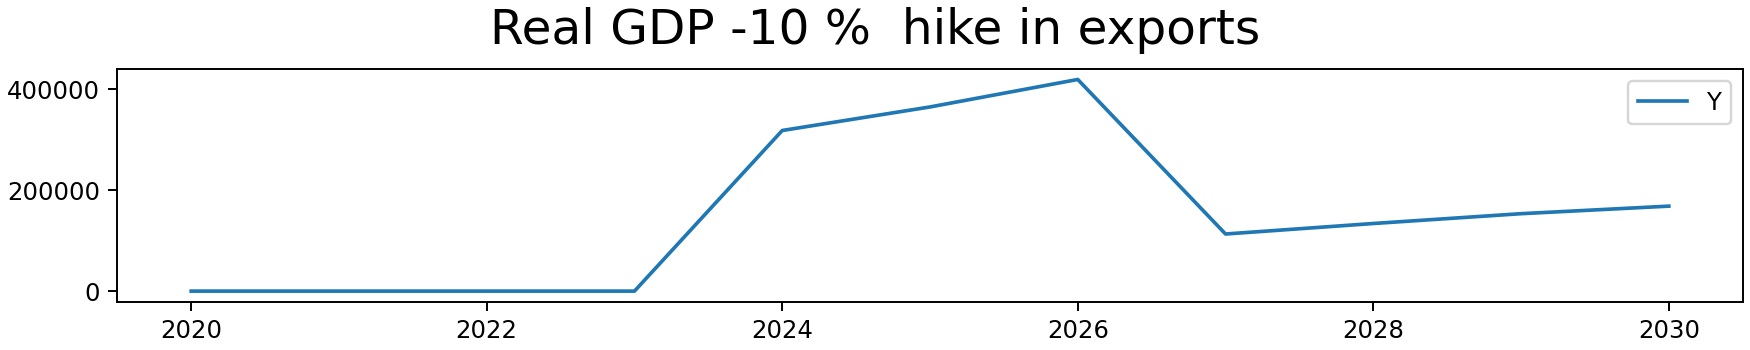

In [19]:
pd.options.display.float_format = '{:.1f}'.format # set the decimal points of the axis
msim['Y'].dif.plot(kind='line',title='Real GDP -10 %  hike in exports',colrow=1,top=0.5)


### Change in the growth rates


<IPython.core.display.Javascript object>


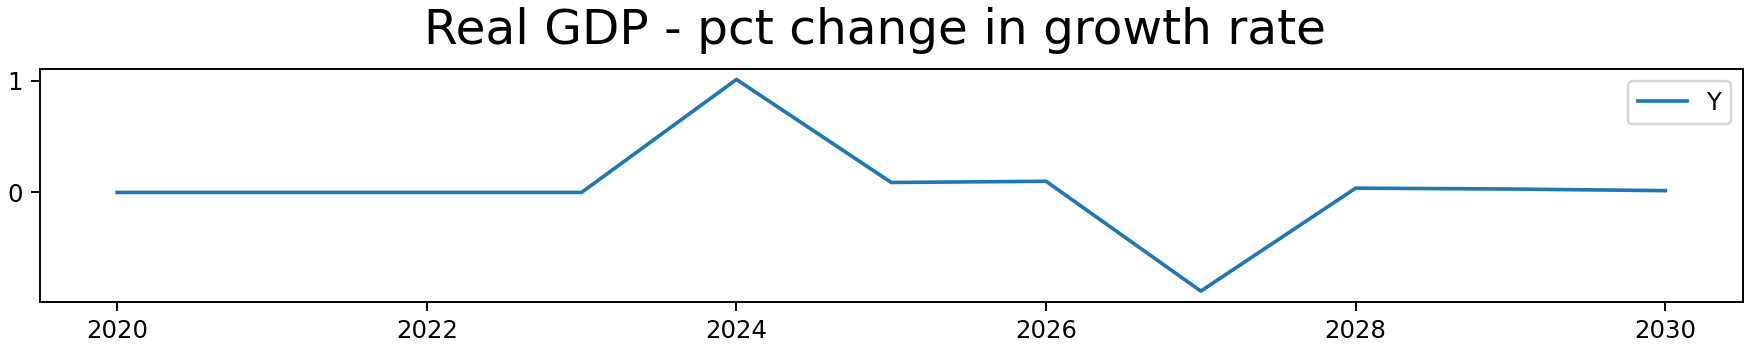

In [20]:
msim['Y'].difpct.mul100.plot(kind='line',title='Real GDP - pct change in growth rate',colrow=1,top=0.8)


<IPython.core.display.Javascript object>


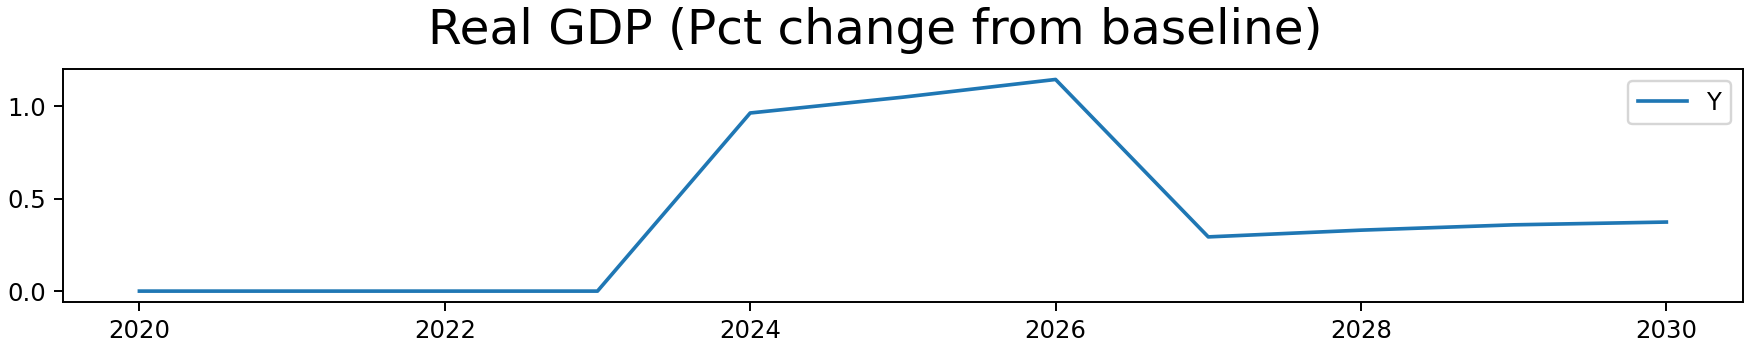

In [25]:

msim['Y'].difpctlevel.mul100.plot(kind='line',title='Real GDP (Pct change from baseline)',colrow=1,top=0.8)

This time with multiple charts drawn from a single command

<IPython.core.display.Javascript object>


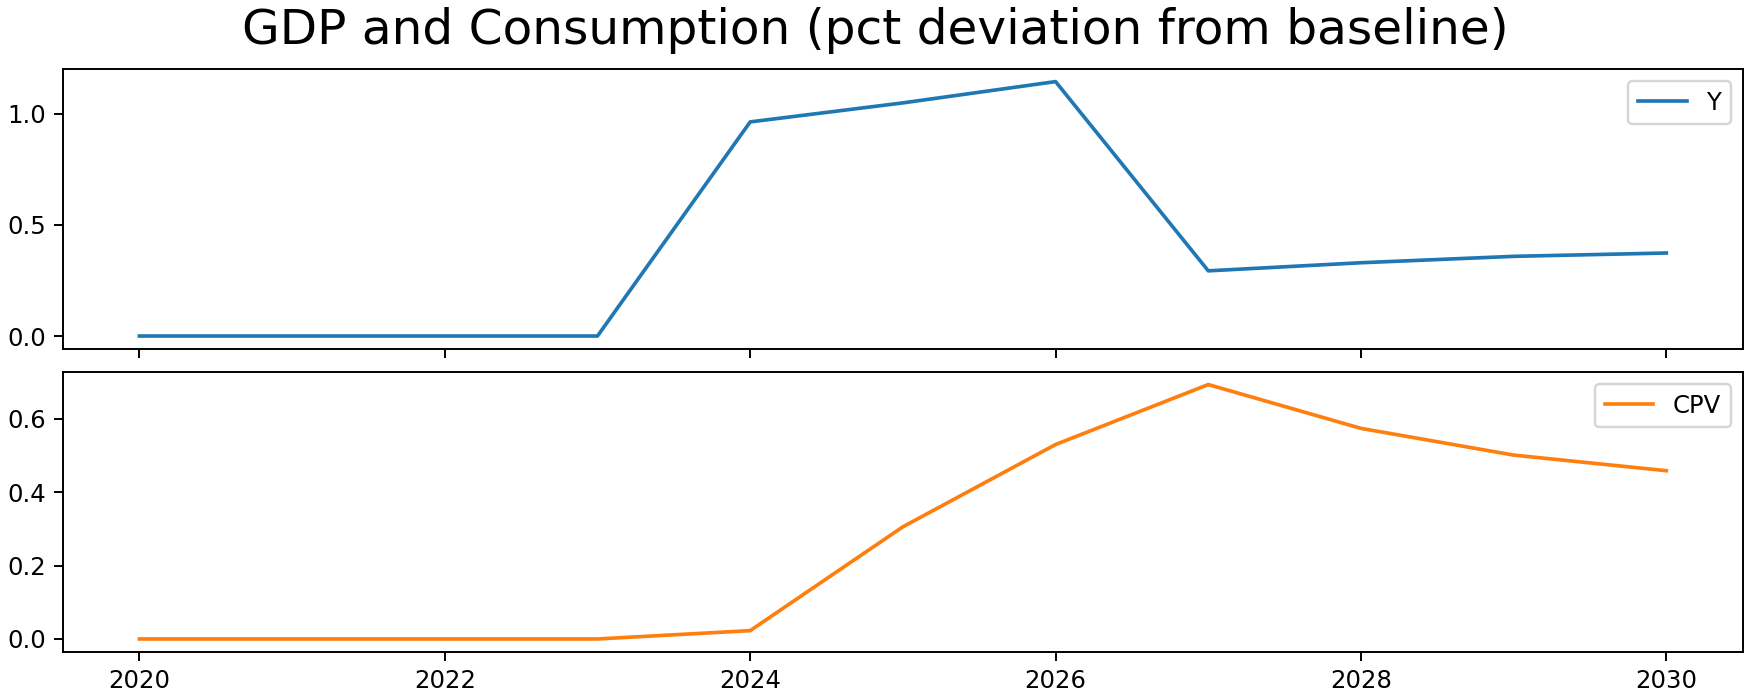

In [26]:
msim['Y CPV'].difpctlevel.mul100.plot(kind='line',title='GDP and Consumption (pct deviation from baseline)',colrow=1,top=0.8)

## Interactive comparisons of results

When working in jupyter books any of the above commands absent the .df or .plot will generate a widget that displays all of these results both as tables and graphs in different tabs.

In [28]:
msim['Y CPV'].difpct
